# 任务三：文本分析与词云图绘制（二选一）

（1）统计英文评论词频，绘制词云图；对中文评论进行分词、统计词频，绘制词云图

In [1]:
import os,sys
SRC_DIR = os.path.join(os.path.abspath('.'), 'data')
print(SRC_DIR)

c:\Users\Administrator\WPSDrive\205034987\WPS云盘\07 绛亽新学习\01 电子商务\05 20级大四上学期\商务智能实验\notebook\data


定义分词类

> 基于雷结巴分词，优化了耗时
> 
> 同一环境下，测试数据优化前posseg_cut_mode耗时 9m 34s ，优化后cut_mode耗时 2m 55s 、posseg_cut_mode耗时 7m 41s

In [2]:
import jieba
import jieba.posseg as pseg # 直接调用 jieba.posseg 有时会报错 jieba 没有 posseg ，不知道为什么
import warnings, os
from collections import Counter

class ChineseSegmentation:
    ''' base on Leijieba
    2023年11月4日更新   ->  支持特定词性筛选'''
    stopwords = []

    def __init__(self, sentence, stopword_file_path='', user_dict_file_path='', debug=False):
        ''''''
        self.sentence = sentence
        self.debug = debug
        self.stopwords = []

        if stopword_file_path != '':
            self.stopwords = [line.strip() for line in open(stopword_file_path, encoding='UTF-8').readlines()]
        else:
            warnings.warn('丫的 stopword_file_path 为空')

        if user_dict_file_path != '':
            jieba.load_userdict(user_dict_file_path)
        else:
            warnings.warn('丫的 user_dict_file_path 为空')

    def _fn_cut_words(self, filter_part_of_speech=False, posseg_cut_mode=False):
        ''''''
        output_words = []
        if os.name == 'posix':  # 在 POSIX 系统上启用并行分词加速
            jieba.enable_parallel()
        if posseg_cut_mode: # 两种处理方案
            seg_list = pseg.cut(self.sentence) # 使用 pseg.cut 进行分词，该方法会返回词性和词的元组列表
            for word, flag in seg_list:  # word 是词，flag 是词性
                if filter_part_of_speech:  # 当 filter_part_of_speech 为 True 时
                    if flag in ['a', 'n']:  # （代表形容词或名词）
                        output_words.append(word)  # 保留这个词
                else:
                    output_words = [word for word, flag in seg_list if word not in self.stopwords]  # 否则，直接返回所有词
        else:
            seg_list = jieba.cut(self.sentence, cut_all=False) # cut_all=False 是精准模式，否则是全模式
            if self.stopwords:
                for word in seg_list:
                    word = word.strip()
                    if word and word not in self.stopwords:
                        output_words.append(word)
                else:
                    output_words = list(seg_list)


        return output_words


    def word_frequency(self, chunk_size=2000):
        ''''''
        word_list = self._fn_cut_words()
        word_dict = {}
        for word in word_list:
            if word not in word_dict:
                word_dict[word] = 1
            else:
                word_dict[word] += 1
        return sorted(word_dict.items(), key=lambda e:e[1], reverse=True)


    def cut_words_filter(self, frequency_threshold=0, remove_single_word=False, filter_part_of_speech=False):
        '''
        因为只有出现频率大于frequency_threshold的单词才会被保留下来
        如果remove_single_word被设置为True，则单个字符的单词将始终被过滤掉
        如果filter_part_of_speech为True，只保留形容词和名词
        优化了数据量大时异常耗时问题，执行速度大幅提升
        '''
        word_list = self._fn_cut_words(filter_part_of_speech, filter_part_of_speech) # 如果需要过滤词性，则进行词性过滤
        word_counter = Counter(word_list)
        removed_list = []

        # 对词频进行排序
        word_dict_sorted = dict(sorted(word_counter.items(), key=lambda e: e[1], reverse=True))

        if remove_single_word:
            # 移除单个字符的词语和低频词语
            filtered_word_list = [word for word in word_list if len(word) > 1 and word_dict_sorted[word] > frequency_threshold]
            removed_list = [word for word in word_list if len(word) == 1 or word_dict_sorted[word] <= frequency_threshold]
        else:
            # 仅移除低频词语
            filtered_word_list = [word for word in word_list if word_dict_sorted[word] > frequency_threshold]
            removed_list = [word for word in word_list if word_dict_sorted[word] <= frequency_threshold]

        if self.debug:
            removed_list_len = len(removed_list)
            if 0 < removed_list_len < 50:
                warnings.warn(f'\t removed_list from filtered_word_list : ( {removed_list_len} ) \n {removed_list} ')
            elif 50 < removed_list_len:
                warnings.warn(f'\t removed_list from filtered_word_list : ( {removed_list_len} ) \n {removed_list[:20]} \n ... \n {removed_list[-20:]} ')

            print('-'*10)

            filtered_word_list_len = len(filtered_word_list)
            if 0 < filtered_word_list_len < 100:
                print(f'\t filtered_word_list : ( {filtered_word_list_len} ) \n {filtered_word_list} ')
            elif 100 < filtered_word_list_len:
                print(f'\t filtered_word_list : ( {filtered_word_list_len} ) \n {filtered_word_list[:40]} \n ... \n {filtered_word_list[-40:]} ')


        return filtered_word_list


分词并保存文件

In [3]:
import pandas as pd
DATA_Chinese = os.path.join(SRC_DIR, "_reviews_detail_chinese.csv")
TXT_DATA_Chinese_jieba = os.path.join(SRC_DIR, '_reviews_detail_chinese.jieba.txt')
TXT_StopWords = os.path.join(SRC_DIR, 'stopwords.txt')
TXT_UserDic = os.path.join(SRC_DIR, 'userdic.txt') # 后面创建
userdic = 'QQ694357845QQ'
txtfile = pd.read_csv(DATA_Chinese)
txtfile
with open(TXT_UserDic,'w', encoding='utf-8') as f:
    f.write(userdic)
s = userdic.join(list(txtfile['comments']))
m = ChineseSegmentation(s, TXT_StopWords, TXT_UserDic)
print('耗时处理，耐心等候……')
filtered_word_list = m.cut_words_filter(1, 1, 0) # 1 等价于 True

s1 = ' '.join(filtered_word_list)

with open(TXT_DATA_Chinese_jieba,'w', encoding='utf-8') as f:
    f.write(s1.replace(f'{userdic}','\n'))
print('-'*10)
with open(TXT_DATA_Chinese_jieba,'r', encoding='utf-8') as f:
    _n = len(f.readlines())
    print(f'\t write {_n} lines to {TXT_DATA_Chinese_jieba}')
    if _n == 0:
        raise ValueError('_reviews_detail_chinese.jieba.txt 为空，建议检查 m.cut_words_filter')
print()
txt = pd.read_csv(TXT_DATA_Chinese_jieba, sep='\t', encoding = 'utf-8', header = None, skip_blank_lines=False) # skip_blank_lines=False 禁用跳过空行
txt

Building prefix dict from the default dictionary ...
Loading model from cache C:\WINDOWS\TEMP\jieba.cache
Loading model cost 0.471 seconds.
Prefix dict has been built successfully.


耗时处理，耐心等候……
----------
	 write 0 lines to c:\Users\Administrator\WPSDrive\205034987\WPS云盘\07 绛亽新学习\01 电子商务\05 20级大四上学期\商务智能实验\notebook\data\_reviews_detail_chinese.jieba.txt



EmptyDataError: No columns to parse from file

绘制词云并保存文件

jieba_save.txt -> 中文词云.png
_reviews_detail_english.csv -> 英文词云.png
******************************************************************************************************************************************************
处理中……
中文词云.png 已生成
处理中……
英文词云.png 已生成


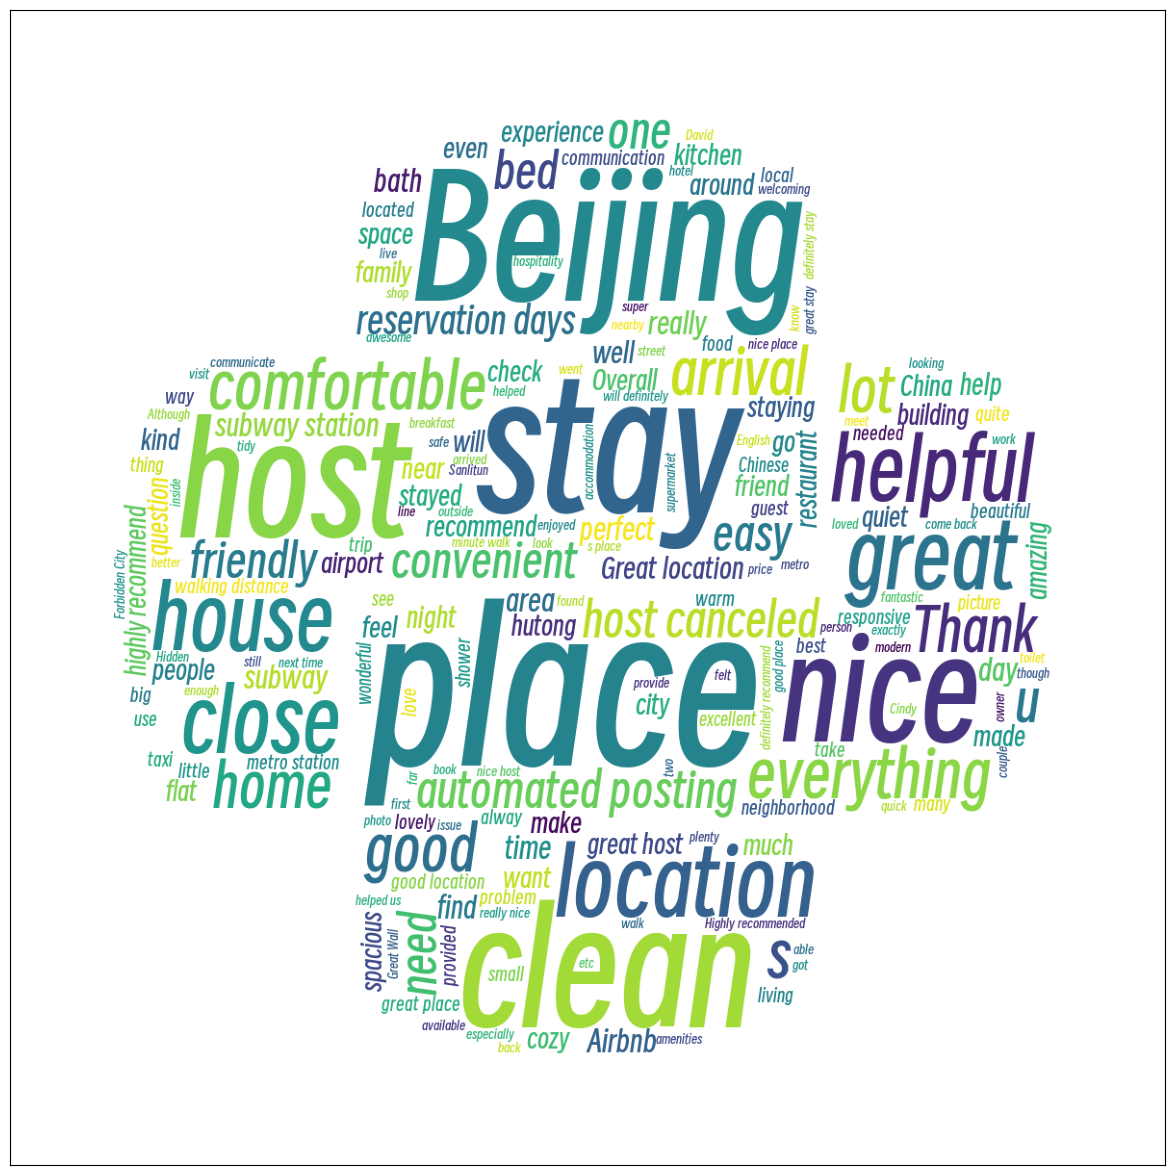

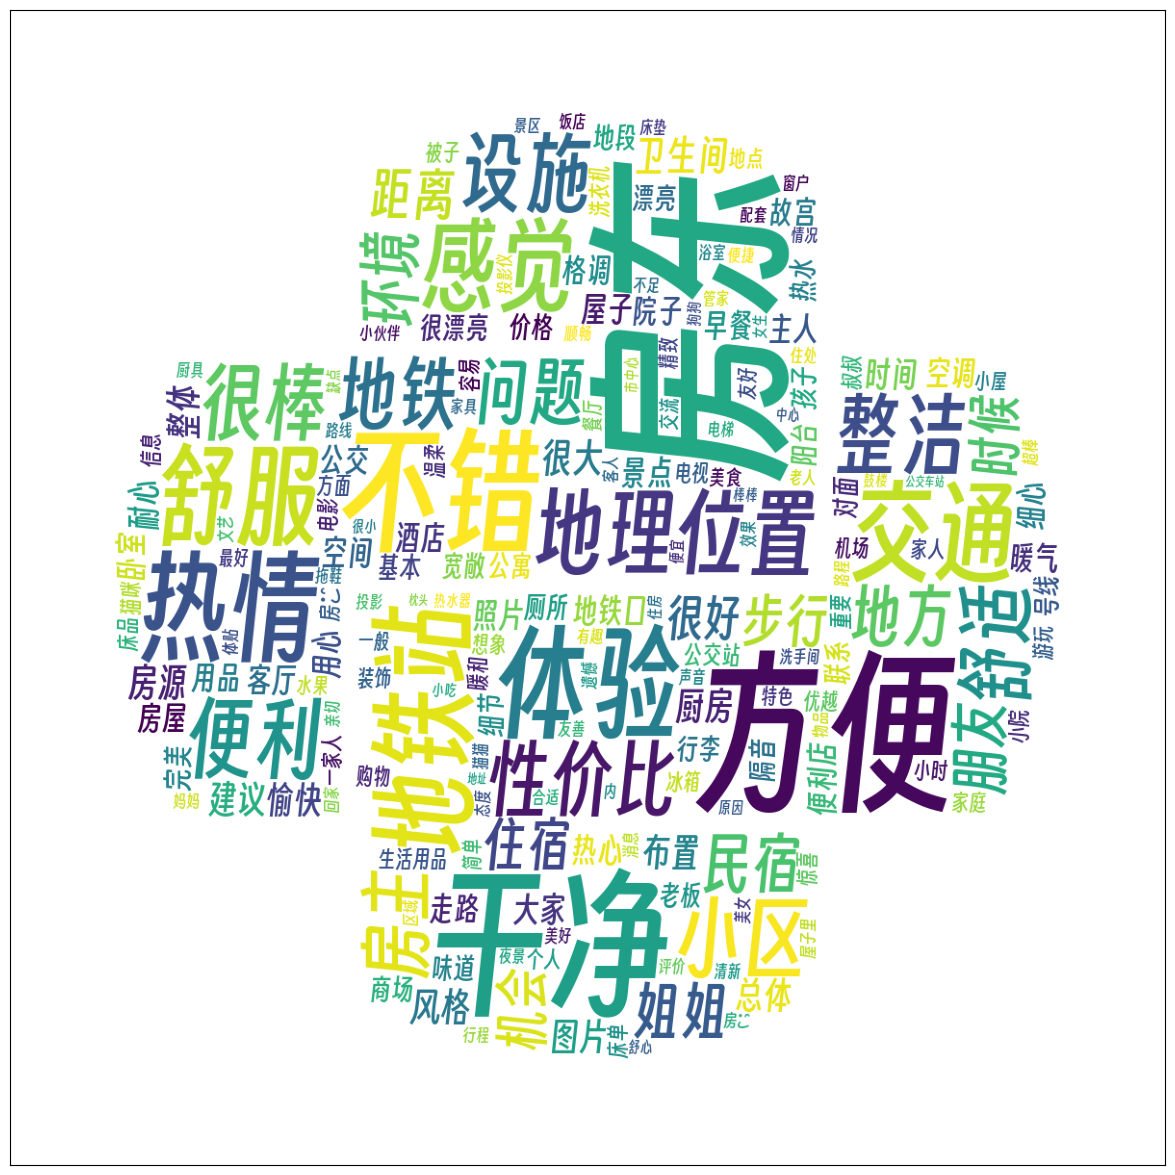

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
print("jieba_save.txt -> 中文词云.png")
print("_reviews_detail_english.csv -> 英文词云.png")
print("*" * 150)
CNP = os.path.join(SRC_DIR, "_output_中文词云.png")
ENP = os.path.join(SRC_DIR, "_output_英文词云.png")
print("处理中……")
with open(os.path.join(SRC_DIR,"_reviews_detail_chinese.jieba.txt"), "r", encoding='utf-8') as file:
    txt = file.read()
re_move = ['的', '一个', '有点', '房子', '房间']  # 需要删除的字或词（影响词云的非关键字）
# 去除无效数据
for i in re_move:
    txt = txt.replace(i, "")

mask = np.array(Image.open(os.path.join(SRC_DIR, 'src', 'python.png')))
font_path = os.path.join(SRC_DIR, 'src', 'SmileySans.ttf')
word = WordCloud(background_color="white",  # 这里是背景颜色
                 width=1500,  # 这里是词云大小
                 height=1500,
                 collocations=False, # 避免重复
                 stopwords=STOPWORDS.add("的"),
                 font_path=font_path,
                 mask=mask  # img -> array, 词云的填充对象
                 ).generate(txt)
word.to_file(CNP)  # 保存图片
print("中文词云.png 已生成")
print("处理中……")
sr = ''
up0 = pd.read_csv(os.path.join(SRC_DIR, '_reviews_detail_english.csv'),
                  usecols=['comments'], encoding='utf-8')
re_move = ['apartment','room']  # 需要删除的字或词（影响词云的非关键字）
for i in up0['comments']:
    for j in re_move:
        i = i.replace(j,'')
    sr = sr + i

en = WordCloud(background_color="white",
               width=1500,
               height=1500,
               stopwords=STOPWORDS.add("a"),
               font_path=font_path,
               mask=mask  # img -> array, 词云的填充对象
               ).generate(sr)
en.to_file(ENP)
print("英文词云.png 已生成")
plt.figure(figsize=(15,15))
plt.gca().xaxis.set_major_locator(plt.NullLocator())  # 去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator())  # 去掉y轴刻度
plt.imshow(Image.open(ENP))
plt.show()
plt.figure(figsize=(15,15))
plt.gca().xaxis.set_major_locator(plt.NullLocator())  # 去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator())  # 去掉y轴刻度
plt.imshow(Image.open(CNP))
plt.show()

#
\- The End -